# Example of using ClinTrajan, illustrated with Myocardial Infarction Dataset


# Part 1. Quantification of Data

### Importing libraries for quantification

In [1]:
from importlib import reload  

import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

from clintraj_qi import *

### Loading data (categorical variables are assumed to be dummy-encoded already)

In [2]:
df = pd.read_csv('data/infarction/all_dummies.txt',delimiter='\t')
display(df)
quantify_nans(df)

,ID,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,...,REC_IM,P_IM_STEN,LET_IS_0,LET_IS_1,LET_IS_2,LET_IS_3,LET_IS_4,LET_IS_5,LET_IS_6,LET_IS_7
0,1,77.0,1,2.0,1.0,1.0,2.0,3.0,0.0,7.0,...,0,0.0,1,0,0,0,0,0,0,0
1,2,55.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,1,0,0,0,0,0,0,0
2,3,52.0,1,0.0,0.0,0.0,2.0,2.0,0.0,2.0,...,0,0.0,1,0,0,0,0,0,0,0
3,4,68.0,0,0.0,0.0,0.0,2.0,2.0,0.0,3.0,...,0,0.0,1,0,0,0,0,0,0,0
4,5,60.0,1,0.0,0.0,0.0,2.0,3.0,0.0,7.0,...,0,0.0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1569,1695,77.0,0,0.0,0.0,0.0,0.0,2.0,0.0,7.0,...,0,0.0,0,0,0,1,0,0,0,0
1570,1696,77.0,0,0.0,4.0,2.0,1.0,2.0,0.0,7.0,...,0,0.0,0,0,0,1,0,0,0,0
1571,1697,70.0,0,0.0,6.0,2.0,1.0,2.0,0.0,7.0,...,0,0.0,0,1,0,0,0,0,0,0
1572,1699,79.0,0,2.0,2.0,2.0,1.0,2.0,0.0,7.0,...,0,0.0,0,1,0,0,0,0,0,0


Missing values 4780 (2.468982758442578%)
Number of complete rows: 533 (33.86277001270648%)


### Detecting variable types

In [4]:
variable_types, binary, continuous, ordinal = detect_variable_type(df,10,verbose=False)

### Simplest univariate quantification (can work when there are missing values)

In [5]:
dfq,replacement_info = quantify_dataframe_univariate(df,variable_types)
with open('temp.txt','w') as fid:
    fid.write(replacement_info)

### Simplest missing value imputation using SVD computed at complete part of the dataset

Matrix shape: (533, 123)
Effective linear dimension 24
Full matrix shape (1574, 123)


,ID,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,...,REC_IM,P_IM_STEN,LET_IS_0,LET_IS_1,LET_IS_2,LET_IS_3,LET_IS_4,LET_IS_5,LET_IS_6,LET_IS_7
0,1,77.0,1,2,1,1,2,3,0,7,...,0,0,1,0,0,0,0,0,0,0
1,2,55.0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,3,52.0,1,0,0,0,2,2,0,2,...,0,0,1,0,0,0,0,0,0,0
3,4,68.0,0,0,0,0,2,2,0,3,...,0,0,1,0,0,0,0,0,0,0
4,5,60.0,1,0,0,0,2,3,0,7,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1569,1695,77.0,0,0,0,0,0,2,0,7,...,0,0,0,0,0,1,0,0,0,0
1570,1696,77.0,0,0,4,2,1,2,0,7,...,0,0,0,0,0,1,0,0,0,0
1571,1697,70.0,0,0,6,2,1,2,0,7,...,0,0,0,1,0,0,0,0,0,0
1572,1699,79.0,0,2,2,2,1,2,0,7,...,0,0,0,1,0,0,0,0,0,0


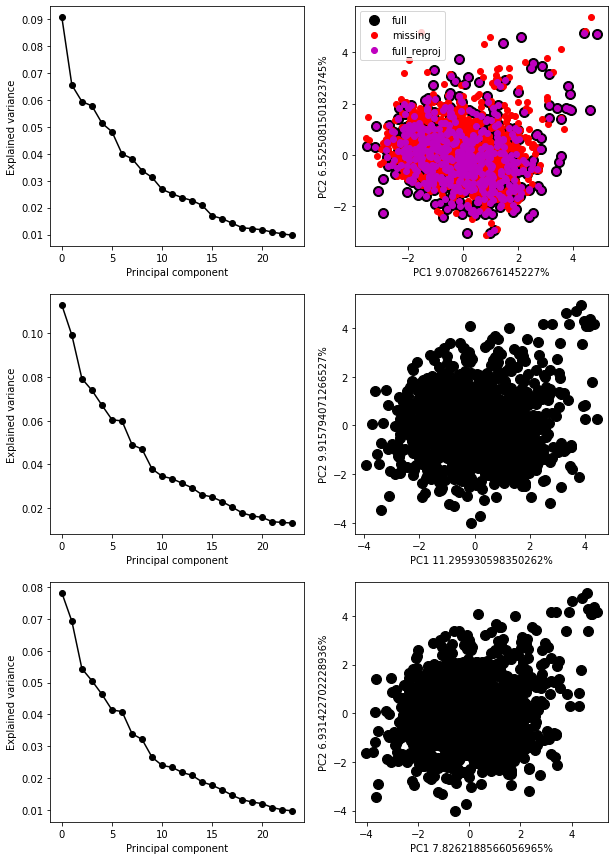

In [6]:
dfq_imputed = SVDcomplete_imputation_method(dfq, variable_types, verbose=True,num_components=-1)
#dequant_info = invert_quant_info(replacement_info)
dequant_info = invert_quant_info(load_quantification_info('temp.txt'))
df_imputed = dequantify_table(dfq_imputed,dequant_info)
display(df_imputed)

## Now we quantify (and optimize) the ordinal variables via optimal scaling

Removing  0 columns

 Initial Q2: 29.800615065363672
Initial quantification table:
[array([0., 1., 2., 3., 4., 5., 6.]), array([0., 1., 2., 3., 4., 5., 6.]), array([0., 1., 2., 3., 4., 8.]), array([0., 1., 2.]), array([0., 1., 2., 3.]), array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7., 10.]), array([0., 1., 2., 3., 4.]), array([0., 1., 2., 3., 4.]), array([0., 1., 2., 3., 4.]), array([0., 1., 2., 3., 4.]), array([0., 1., 2., 3., 4.]), array([1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([0., 1., 2., 3., 4., 6., 7.]), array([0., 1., 2., 3.]), array([0., 1., 2., 4.]), array([ 0.,  1., 10.]), array([0., 1., 2., 3., 4., 5., 6.]), array([0., 1., 2., 3.]), array([0., 1., 2.]), array([0., 1., 2., 3., 4.]), array([0., 1., 2., 3.]), array([0., 1., 2.])]
Monotonicity: (True, 1.0)
Iteration 0 Q2= 29.800615065363672
Iteration 1 Q2= 29.800615065363644
Iteration 2 Q2= 30.275887670513086
Iteration 3 Q2= 30.82859530474653
Iteration 4 Q2= 30.866213116176908
Iteration 5 Q2= 30.88270280026677
Iteration 6 Q2= 

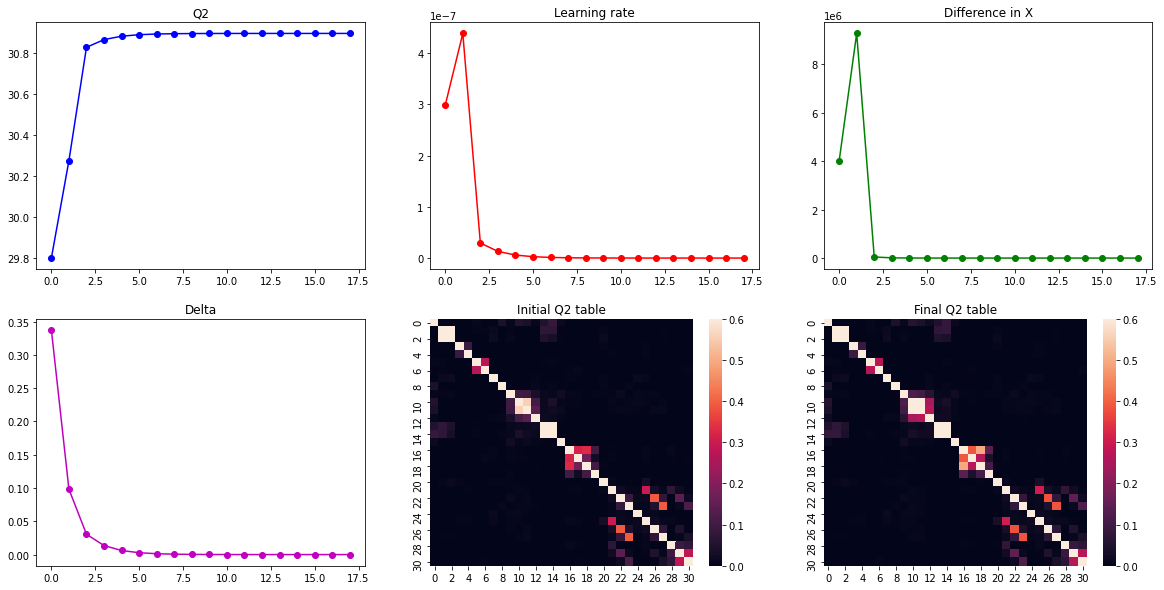

In [25]:
df = remove_constant_columns_from_dataframe(df_imputed)
variable_names = [str(s) for s in df.columns[1:]]
X = df[df.columns[1:]].to_numpy()
X_original = X
X_before_scaling = X.copy()
X,cik = optimal_scaling(X,variable_types,verbose=True,vmax=0.6)

#### OK, we finished preparing the data matrix X, which is now complete and properly quantified. We also keep the 'original matrix' X_original, with 'raw' values of the variables (will be needed for visualizations)

# Part 2. Computing the principal tree

## Loading ClinTrajan libraries

In [38]:
from clintraj_eltree import *
from clintraj_util import *
from clintraj_ml import *
from clintraj_optiscale import *

## First of all, we will reduce the dimension using PCA

In [31]:
reduced_dimension = 12
X = scipy.stats.zscore(X)
pca = PCA(n_components=X.shape[1],svd_solver='full')
Y = pca.fit_transform(X)
v = pca.components_.T
mean_val = np.mean(X,axis=0)
X = Y[:,0:reduced_dimension]

## We are ready to compute the principal tree, let us do it

['/mnt/c/Datas/Golovenkin', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '', '/home/zinovyev/.local/lib/python3.7/site-packages', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/home/zinovyev/.local/lib/python3.7/site-packages/IPython/extensions', '/home/zinovyev/.ipython', '/home/zinovyev/anaconda3/lib/python3.7/site-packages', '/home/zinovyev/anaconda3/lib/python3.7/site-packages', '/home/zinovyev/anaconda3/lib/python3.7/site-packages']
['/mnt/c/Datas/Golovenkin', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '', '/home/zinovyev/.local/lib/python3.7/site-packages', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/home/zinovyev/.local/lib/python3.7/site-packages/IPython/extensions', '/home/zinovyev/.ipython', '/home/zinovyev/anaconda3/lib/python3.7/site-packages', '/home/zinovyev/anaconda3/lib/python3.7/site-packages', '/home/zinovyev/anaconda3/lib/python3.

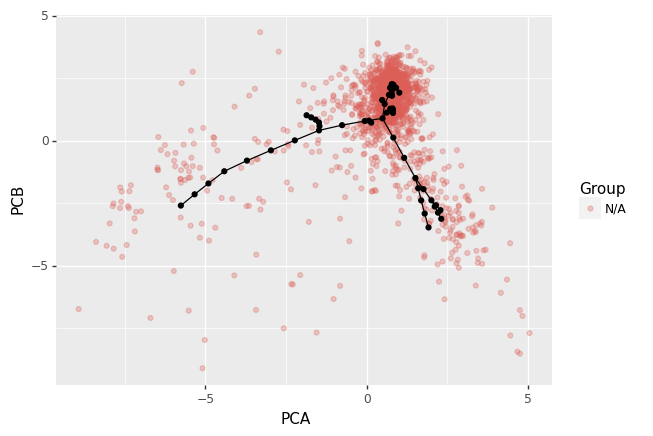

[<ggplot: (8756608849717)>]
Removed 3 vertices and 3 edges


In [39]:
import sys
print(sys.path)
sys.path.append('/home/zinovyev/anaconda3/lib/python3.7/site-packages')
print(sys.path)

nnodes = 50
tree_elpi = elpigraph.computeElasticPrincipalTree(X,nnodes,drawPCAView=True,
                                                  alpha=0.01,Mu=0.1,Lambda=0.05,
                                                  FinalEnergy='Penalized')
tree_elpi = tree_elpi[0]
# some additional pruning of the graph
prune_the_tree(tree_elpi)
# extend the leafs to reach the extreme data points
tree_extended = ExtendLeaves_modified(X, tree_elpi, Mode = "QuantDists", ControlPar = .5, DoSA = False)

## Now we will create two data partitioning, by nodes of the principal tree and by the linear segments of the principal tree

In [40]:
# paritioning the data by tree branches
vec_labels_by_branches = partition_data_by_tree_branches(X,tree_extended)
print(len(set(vec_labels_by_branches)),'labels generated')
# paritioning the data by proximity to nodes
nodep = tree_elpi['NodePositions']
partition, dists = elpigraph.src.core.PartitionData(X = X, NodePositions = nodep, 
                                                    SquaredX = np.sum(X**2,axis=1,keepdims=1),
                                                    MaxBlockSize = 100000000, TrimmingRadius = np.inf
                                                    )
partition_by_node = np.zeros(len(partition))
for i,p in enumerate(partition):
    partition_by_node[i] = p[0]

14 labels generated


## Let us visualize the tree, with data points, colored by the tree segments

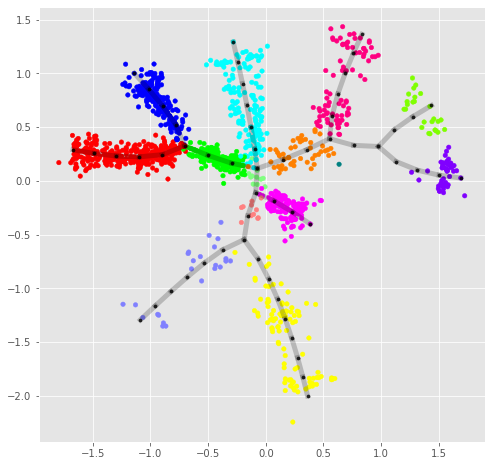

In [47]:
fig = plt.figure(figsize=(8, 8))
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,'k',variable_names,
                          Color_by_partitioning = True, visualize_partition = vec_labels_by_branches)
plt.show()

## Now let us show, on top of the tree, lethal cases, and show the lethality trend by the edge width

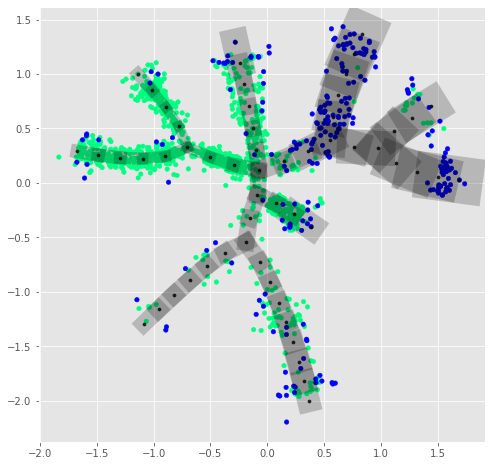

In [62]:
a

## Let us higlight patients with AGE<65 and having bronchyal asthma in their anamneses

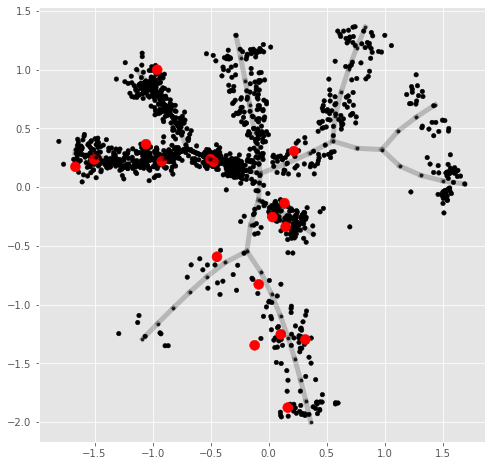

In [101]:
fig = plt.figure(figsize=(8, 8))
inds = np.where((X_original[:,variable_names.index('AGE')]<=65)&(X_original[:,variable_names.index('zab_leg_03')]==1))[0]
colors = ['k' for i in range(len(X))]
for i in inds:
    colors[i] = 'r'
colors = list(colors)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,colors,variable_names,
                          highlight_subset=inds,Big_Point_Size=100,cmap='hot')

plt.show()

## Now let us quantify the pseudotime value, for each trajectory

#### 1. We need to specify the root node. In order to do this, we will highlight all cases without any myocardial infarction complications, and will select the node where the complications are rare. In order to make the selection visual, we will show the node numbers as well

['r', 'k'] [945 629]


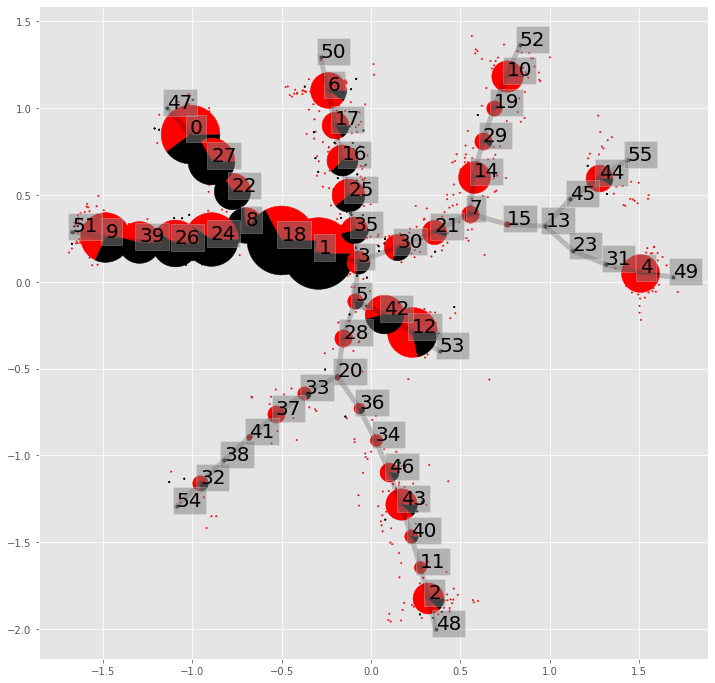

Root node= 8


In [140]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1,1,1)
complication_vars = ['FIBR_PREDS','PREDS_TAH','JELUD_TAH','FIBR_JELUD',
                     'A_V_BLOK','OTEK_LANC','RAZRIV','DRESSLER',
                     'ZSN','REC_IM','P_IM_STEN']
inds_compl = [variable_names.index(a) for a in complication_vars]
lethal = 1-X_original[:,variable_names.index('LET_IS_0')]
has_complication = np.sum(X_original[:,inds_compl],axis=1)>0
inds = np.where((has_complication==0)&(lethal==0))[0]
colors = ['r' for i in range(len(X))]
for i in inds:
    colors[i] = 'k'
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,colors,variable_names,
                          highlight_subset=inds,Big_Point_Size=2,Normal_Point_Size=2,showNodeNumbers=True)
add_pie_charts(ax,tree_extended['NodePositions2D'],colors,['r','k'],partition,scale=30)
plt.show()
root_node = 8
print('Root node=',8)

#### 2. Now we are ready to quantify pseudo-time

In [144]:
all_trajectories,all_trajectories_edges = extract_trajectories(tree_extended,root_node)
print(len(all_trajectories),' trajectories found.')
ProjStruct = project_on_tree(X,tree_extended)
PseudoTimeTraj = quantify_pseudotime(all_trajectories,all_trajectories_edges,ProjStruct)

9  trajectories found.


#### 3. Let us find all associations by regression of a clinical variable with pseudotime along all trajectories

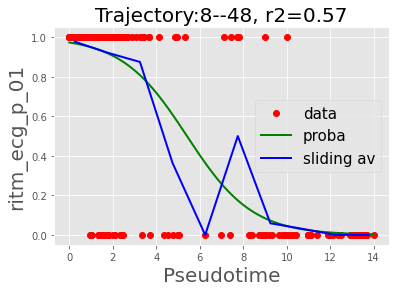

1 ('Trajectory:8--48', 'ritm_ecg_p_01', 0.5707779886148008)


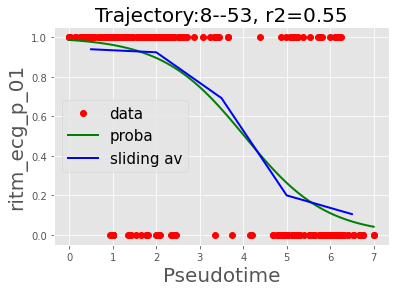

6 ('Trajectory:8--53', 'ritm_ecg_p_01', 0.5491269841269841)


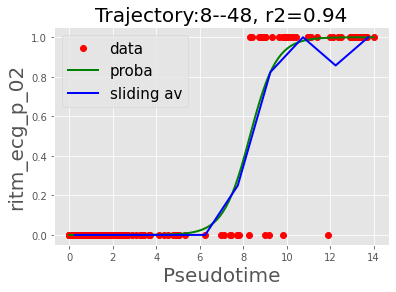

1 ('Trajectory:8--48', 'ritm_ecg_p_02', 0.9423870867608257)


/mnt/c/Datas/Golovenkin/clintraj_util.py:101: RuntimeWarning: invalid value encountered in true_divide
  bin_avgs = vals / counts


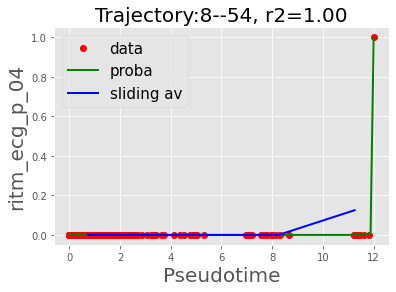

7 ('Trajectory:8--54', 'ritm_ecg_p_04', 1.0)


/mnt/c/Datas/Golovenkin/clintraj_util.py:101: RuntimeWarning: invalid value encountered in true_divide
  bin_avgs = vals / counts


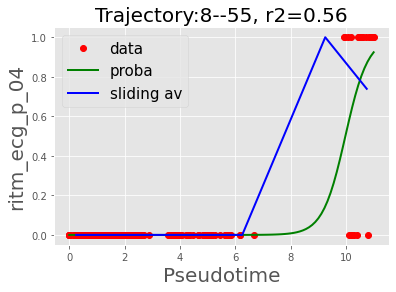

8 ('Trajectory:8--55', 'ritm_ecg_p_04', 0.5590468709086148)


In [160]:
vars = ['ritm_ecg_p_01','ritm_ecg_p_02','ritm_ecg_p_04']
for var in vars:
    List_of_Associations = regression_of_variable_with_trajectories(PseudoTimeTraj,var,variable_names,
                                                                    variable_types,X_original,R2_Threshold=0.5,
                                                                    producePlot=True,
                                                                    Continuous_Regression_Type='gpr',
                                                                    verbose=True)

#### 4. We can plot several variable dependencies against pseudotime

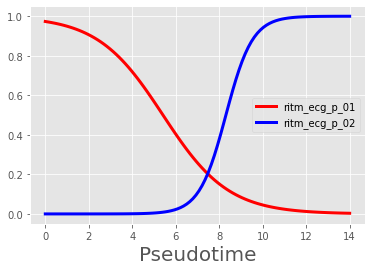

In [164]:
pstt = PseudoTimeTraj[1]
colors = ['r','b','g']
for i,var in enumerate(vars):
    vals = draw_pseudotime_dependence(pstt,var,variable_names,variable_types,X_original,colors[i],
                                               linewidth=3,draw_datapoints=False)
plt.legend()
plt.show()


#### 5. Now let us show how we can plot anything as a function of pseudotime, for example, cumulative hazard of death estimated using standard survival analysis

/home/zinovyev/anaconda3/lib/python3.7/site-packages/lifelines/fitters/nelson_aalen_fitter.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.ci_labels[0]: hazard_ * np.exp(z * std_hazard_ / hazard_),
/home/zinovyev/anaconda3/lib/python3.7/site-packages/lifelines/fitters/nelson_aalen_fitter.py:235: RuntimeWarning: invalid value encountered in true_divide
  self.ci_labels[1]: hazard_ * np.exp(-z * std_hazard_ / hazard_),
/home/zinovyev/anaconda3/lib/python3.7/site-packages/lifelines/fitters/nelson_aalen_fitter.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.ci_labels[0]: hazard_ * np.exp(z * std_hazard_ / hazard_),
/home/zinovyev/anaconda3/lib/python3.7/site-packages/lifelines/fitters/nelson_aalen_fitter.py:235: RuntimeWarning: invalid value encountered in true_divide
  self.ci_labels[1]: hazard_ * np.exp(-z * std_hazard_ / hazard_),
/home/zinovyev/anaconda3/lib/python3.7/site-packages/lifelines/fitters/nelson_aalen_fitter.py:234: RuntimeWarn

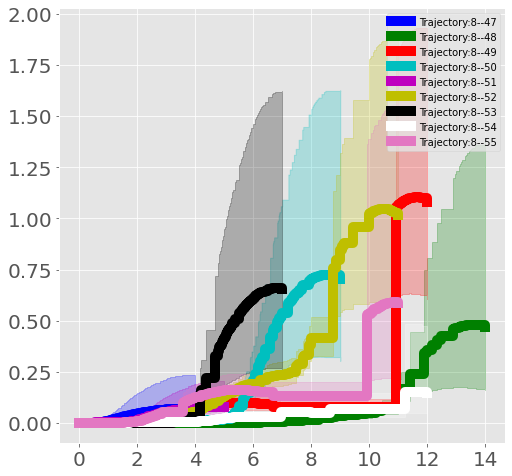

In [179]:
import lifelines
from lifelines import SplineFitter
from lifelines import NelsonAalenFitter
from lifelines import KaplanMeierFitter
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w','tab:pink','tab:green']

event_data = np.zeros((len(df),2))
events = 1-np.array(df['LET_IS_0'])
label = 'Death'

for i,pstt in enumerate(PseudoTimeTraj):
    points = pstt['Points']
    times = pstt['Pseudotime']
    for i,p in enumerate(points):
        event_data[p,0] = times[i]
        event_data[p,1] = events[p]

plt.figure(figsize=(8,8))

for i,pstt in enumerate(PseudoTimeTraj):
    TrajName = 'Trajectory:'+str(pstt['Trajectory'][0])+'--'+str(pstt['Trajectory'][-1])
    points = pstt['Points']
    naf = NelsonAalenFitter()
    T = event_data[points,0]
    E = event_data[points,1]
    naf.fit(event_data[points,0], event_observed=event_data[points,1],label=TrajName)  
    naf.plot_hazard(bandwidth=3.0,fontsize=20,linewidth=10,color=colors[i])

